## Context
After watching School for sommelier (a documentary on master sommeliers) I wondered how I could create a predictive model to identify wines through blind tasting like a master sommelier would. The first step in this journey was gathering some data to train a model. I plan to use deep learning to predict the wine variety using words in the description/review. The model still won't be able to taste the wine, but theoretically it could identify the wine based on a description that a sommelier could give. If anyone has any ideas on how to accomplish this, please post them


I'll start exploring the data to find for interesting informations about the wine quality based on the sommeliers comments. 

After it, I will try to predict the wine region, based on the review of the sommeliers.


## I will try answer a batch of questions, like:

- Have an Provinces the same number of wines? <br>
- Whats the distribuition of Price and Points by Province? <br>
- Whats the country distribuition<br>
- Taking a look on the word clouds.    <br>
     

## Importing Libraries

In [41]:
import pandas as pd #Library to handle with dataframes
import matplotlib.pyplot as plt # Library to plot graphics
import numpy as np # To handle with matrices
import seaborn as sns # to build modern graphics
from scipy.stats import kurtosis, skew # it's to explore some statistics of numerical values
from scipy import stats
import re

# Not so typical
import matplotlib.image as image
import matplotlib.colors
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from IPython.display import Image as im
import squarify as sq
import warnings
warnings.filterwarnings('ignore')

## Functions def

In [42]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def CalcOutliers(df_num): 
    '''
    
    Leonardo Ferreira 20/10/2018
    Set a numerical value and it will calculate the upper, lower and total number of outliers
    It will print a lot of statistics of the numerical feature that you set on input
    
    '''
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Identified outliers: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return



In [43]:
# Importing our dataset in variable df_wine1
df_wine1 = pd.read_csv('wine.csv', index_col=0)

<h2>Let's take a first look on our data</h2>

- A simple histogram can be a great first step in understanding a dataset. <br>

*I will start with univariate analysis and after it, I will cross some features by the numerical *

In [44]:
resumetable(df_wine1)

Dataset Shape: (1103, 10)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,country,object,0,22,US,Spain,US,2.60
1,description,object,0,1061,This tremendous 100% varietal wine hails from ...,"Ripe aromas of fig, blackberry and cassis are ...",Mac Watson honors the memory of a wine once ma...,10.03
2,designation,object,269,714,Martha's Vineyard,Carodorum Selecci√≥n Especial Reserva,Special Selected Late Harvest,9.29
3,points,int64,0,12,96,96,96,3.19
4,price,float64,57,100,235.0,110.0,90.0,5.79
5,province,object,0,100,California,Northern Spain,California,4.47
6,region_1,object,173,214,Napa Valley,Toro,Knights Valley,6.82
7,region_2,object,611,18,Napa,NaN,Sonoma,3.27
8,variety,object,0,124,Cabernet Sauvignon,Tinta de Toro,Sauvignon Blanc,5.23
9,winery,object,0,846,Heitz,Bodega Carmen Rodr√≠guez,Macauley,9.58


<h2>Let's start looking the distribuition of Points and Prices </h2>

In [45]:
# The function describe is focused on numerical features
# in this case are points and price
print("Statistics of numerical data: ")
print(df_wine1.describe())

Statistics of numerical data: 
            points        price
count  1103.000000  1046.000000
mean     89.701723    40.242830
std       2.390405    32.588141
min      85.000000     7.000000
25%      88.000000    20.000000
50%      90.000000    31.000000
75%      91.000000    50.000000
max      96.000000   500.000000


Very interesting distribuition of Points and Price.
- We can see that the values of points are distributed between 80 and 100
- The price have a high difference between the values and a high standard deviation
- In prices, the IQR (Interquantil Range) is 7. The max value is 500;

We will explore it further later, lets start. 

# Points Distribution
- I will start exploring points and after I will see the same on price
- Let's see the points distributions and quantiles

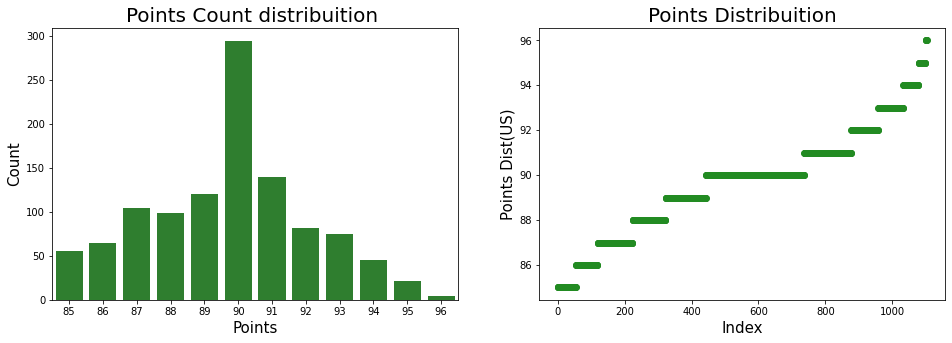

In [46]:
# define the size of figures that I will build
plt.figure(figsize=(16,5))

plt.subplot(1,2,1) # this will create a grid of 1 row and 2 columns; this is the first graphic
g = sns.countplot(x='points', data=df_wine1, color='forestgreen') # seting the seaborn countplot to known the points distribuition
g.set_title("Points Count distribuition ", fontsize=20) # seting title and size of font
g.set_xlabel("Points", fontsize=15) # seting xlabel and size of font
g.set_ylabel("Count", fontsize=15) # seting ylabel and size of font

plt.subplot(1,2,2)  # this will set the second graphic of our grid
plt.scatter(range(df_wine1.shape[0]), np.sort(df_wine1.points.values), color='forestgreen') # creating a cumulative distribution
plt.xlabel('Index', fontsize=15)  # seting xlabel and size of font
plt.ylabel('Points Dist(US)', fontsize=15)  # seting ylabel and size of font
plt.title("Points Distribuition", fontsize=20) # seting title and size of font

plt.show() #rendering the graphs

We can clearly see the distribuition of the data. It seems very similar with a normal distribution. 

As Points are one of the most important metrics in this dataset, I will explore it further more. 

I will find for more important informations like quantiles and maybe try to set wines in categories based on it

## Let's set the points into categories.
- I will create a new feature containing the range of the points with a rank to this pontuations

In [47]:
def cat_points(points):
    if points in list(range(80,83)):
        return 0
    elif points in list(range(83,87)):
        return 1
    elif points in list(range(87,90)):
        return 2
    elif points in list(range(90,94)):
        return 3
    elif points in list(range(94,98)):
        return 4
    else:
        return 5

df_wine1["rating_cat"] = df_wine1["points"].apply(cat_points)

## Ploting Rating categories
- Let's see the distribution after the transformation

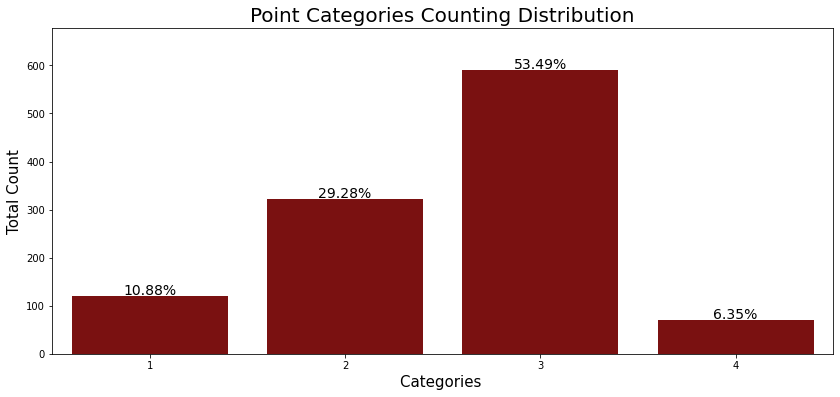

In [48]:
total = len(df_wine1)
plt.figure(figsize=(14,6))

g = sns.countplot(x='rating_cat', color='darkred',
                  data=df_wine1)
g.set_title("Point Categories Counting Distribution", fontsize=20)
g.set_xlabel("Categories ", fontsize=15)
g.set_ylabel("Total Count", fontsize=15)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

Nice! Now we can have a clearly understand of our data in a more clean way. It could be interesting to compare each other regions; 

to 

## Detecting Outlier Points

In [49]:
CalcOutliers(df_wine1['points'])

Identified lowest outliers: 0
Identified upper outliers: 0
Identified outliers: 0
Non-outlier observations: 1103
Total percentual of Outliers:  0.0


# Price Distribution

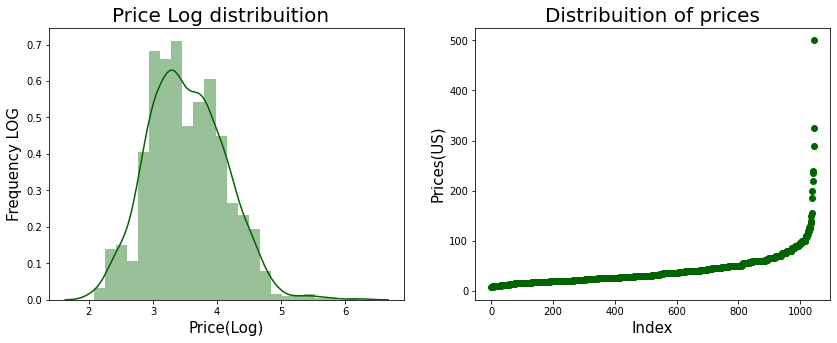

In [50]:
plt.figure(figsize=(14,5))

g1 = plt.subplot(121)
g1 = sns.distplot(np.log(df_wine1['price'].dropna() + 1),
                  color='darkgreen')
g1.set_title("Price Log distribuition  ", fontsize=20)
g1.set_xlabel("Price(Log)", fontsize=15)
g1.set_ylabel("Frequency LOG", fontsize=15)

plt.subplot(122)
plt.scatter(range(df_wine1.shape[0]), np.sort(df_wine1.price.values), 
            color='darkgreen')
plt.xlabel('Index', fontsize=15)
plt.ylabel('Prices(US)', fontsize=15)
plt.title("Distribuition of prices", fontsize=20)


plt.show()

## Outliers in Prices

In [51]:
CalcOutliers(df_wine1['price'])

Identified lowest outliers: 0
Identified upper outliers: 11
Identified outliers: 11
Non-outlier observations: 1035
Total percentual of Outliers:  1.0628


Cool. Now we can clearly see that we have about 1% of outliers.

# Let's see a filtered distribution of Prices

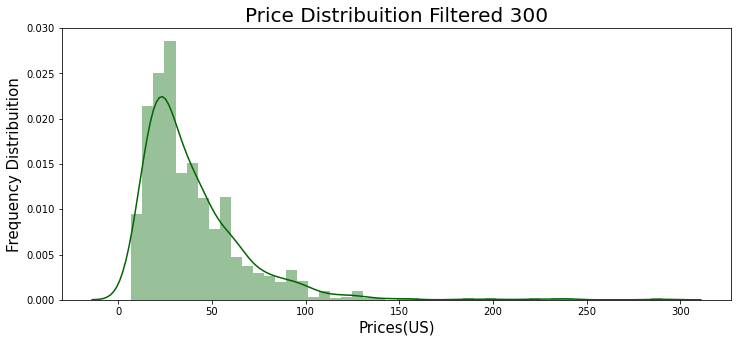

In [52]:
plt.figure(figsize=(12,5))

g = sns.distplot(df_wine1[df_wine1['price'] < 300]['price'], color='darkgreen')
g.set_title("Price Distribuition Filtered 300", fontsize=20)
g.set_xlabel("Prices(US)", fontsize=15)
g.set_ylabel("Frequency Distribuition", fontsize=15)


plt.show()

Nice. It confirms what we saw in the above exploration. The greastest part of all analyzed wines have values under $ 100;

In [53]:
# Let's get tehe price_log to better work with this feature
df_wine1['price_log'] = np.log(df_wine1['price'])

## Crossing prices and Points

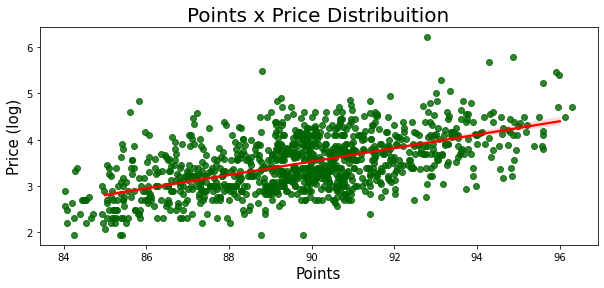

In [54]:
plt.figure(figsize=(10,4))

g = sns.regplot(x='points', y='price_log', 
                data=df_wine1, line_kws={'color':'red'},
                x_jitter=True, fit_reg=True, color='darkgreen')
g.set_title("Points x Price Distribuition", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price (log)", fontsize= 15)

plt.show()

Very meaningful scatter plot. 
- The highest prices isn't of the wine with highest pontuation. 
- The most expensive wine have ponctuation between 87 and 90

Maybe it would be interesting to build an recommender system to find cheapest wines with the same quality.

# Country Feature

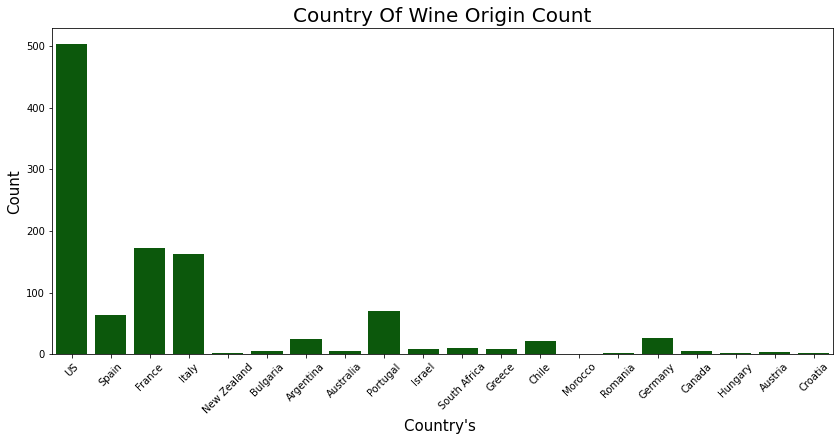

In [55]:
plt.figure(figsize=(14,6))

country = df_wine1.country.value_counts()[:20]

g = sns.countplot(x='country', 
                  data=df_wine1[df_wine1.country.isin(country.index.values)],
                 color='darkgreen')
g.set_title("Country Of Wine Origin Count", fontsize=20)
g.set_xlabel("Country's ", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.show()

Wow, very interesting distribuition. I was expecting to see Italy, Chile or Argentina as the biggest wine productor. <br>
 If you want take a better look, look the print output below

## Now, I will take a look in the distribuition of this top 20 countrys by price and rating

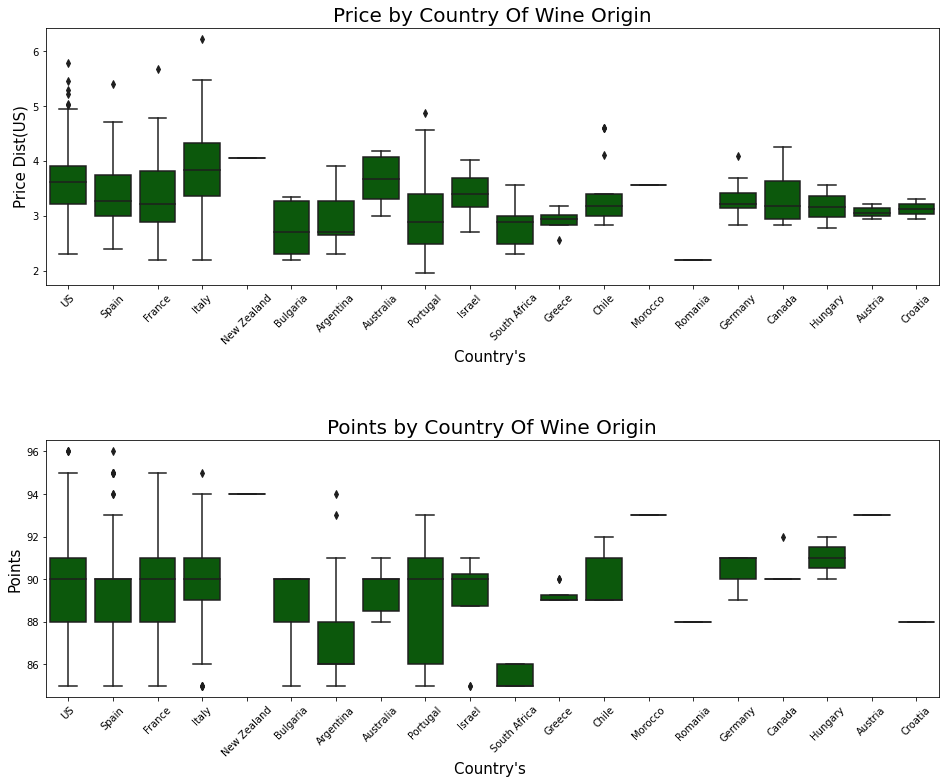

In [56]:
plt.figure(figsize=(16,12))

plt.subplot(2,1,1)
g = sns.boxplot(x='country', y='price_log',
                  data=df_wine1.loc[(df_wine1.country.isin(country.index.values))],
                 color='darkgreen')
g.set_title("Price by Country Of Wine Origin", fontsize=20)
g.set_xlabel("Country's ", fontsize=15)
g.set_ylabel("Price Dist(US)", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.subplot(2,1,2)
g1 = sns.boxplot(x='country', y='points',
                   data=df_wine1[df_wine1.country.isin(country.index.values)],
                 color='darkgreen')
g1.set_title("Points by Country Of Wine Origin", fontsize=20)
g1.set_xlabel("Country's ", fontsize=15)
g1.set_ylabel("Points", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace = 0.6,top = 0.9)

plt.show()

## Taking a look on values lowest than 500

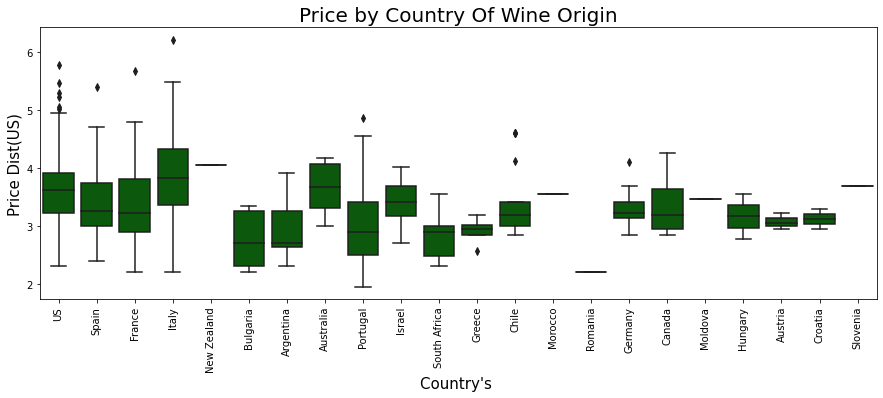

In [57]:
plt.figure(figsize=(15,5))
g = sns.boxplot(x='country', y='price_log', color='darkgreen',
                  data=df_wine1)
g.set_title("Price by Country Of Wine Origin", fontsize=20)
g.set_xlabel("Country's ", fontsize=15)
g.set_ylabel("Price Dist(US)", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.show()

## Province Exploration

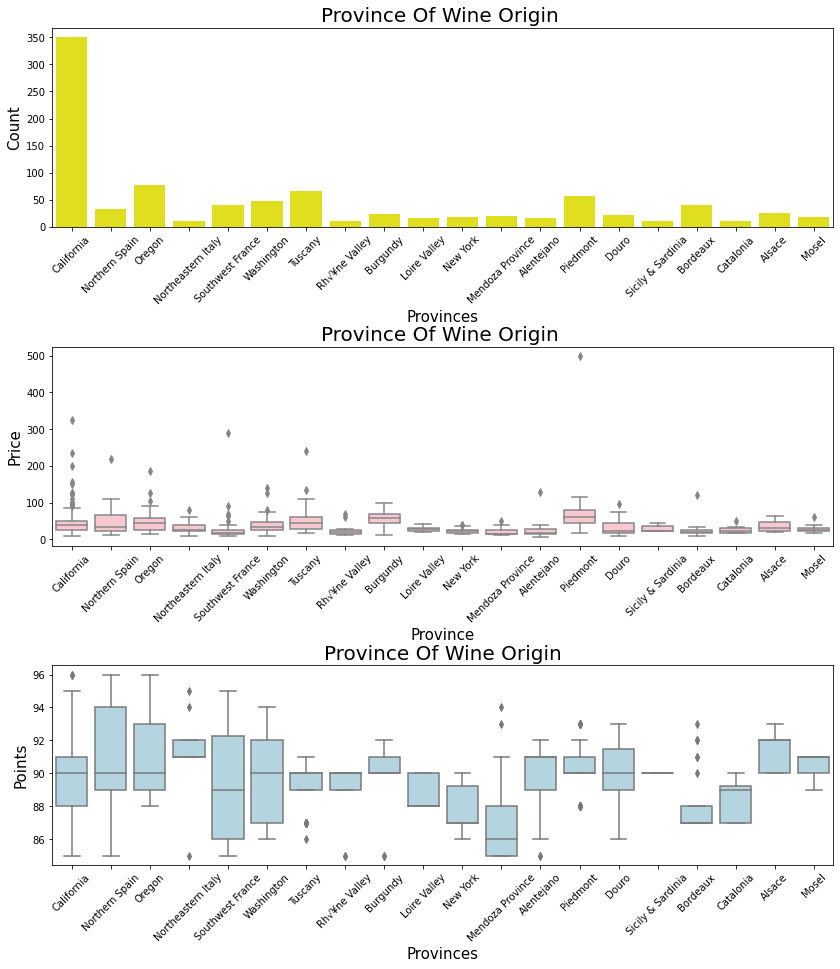

In [58]:
plt.figure(figsize=(14,15))

provinces = df_wine1['province'].value_counts()[:20]

plt.subplot(3,1,1)
g = sns.countplot(x='province', 
                  data=df_wine1.loc[(df_wine1.province.isin(provinces.index.values))], 
                  color='yellow')
g.set_title("Province Of Wine Origin ", fontsize=20)
g.set_xlabel("Provinces", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.subplot(3,1,2)
g1 = sns.boxplot(y='price', x='province',
                  data=df_wine1.loc[(df_wine1.province.isin(provinces.index.values))], 
                  color='pink')
g1.set_title("Province Of Wine Origin ", fontsize=20)
g1.set_xlabel("Province", fontsize=15)
g1.set_ylabel("Price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)

plt.subplot(3,1,3)
g2 = sns.boxplot(y='points', x='province',
                  data=df_wine1.loc[(df_wine1.province.isin(provinces.index.values))], 
                  color='lightblue')
g2.set_title("Province Of Wine Origin", fontsize=20)
g2.set_xlabel("Provinces", fontsize=15)
g2.set_ylabel("Points", fontsize=15)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace = 0.6,top = 0.9)

plt.show()

## PROVINVCE FEATURE

## VARIETY FEATURE

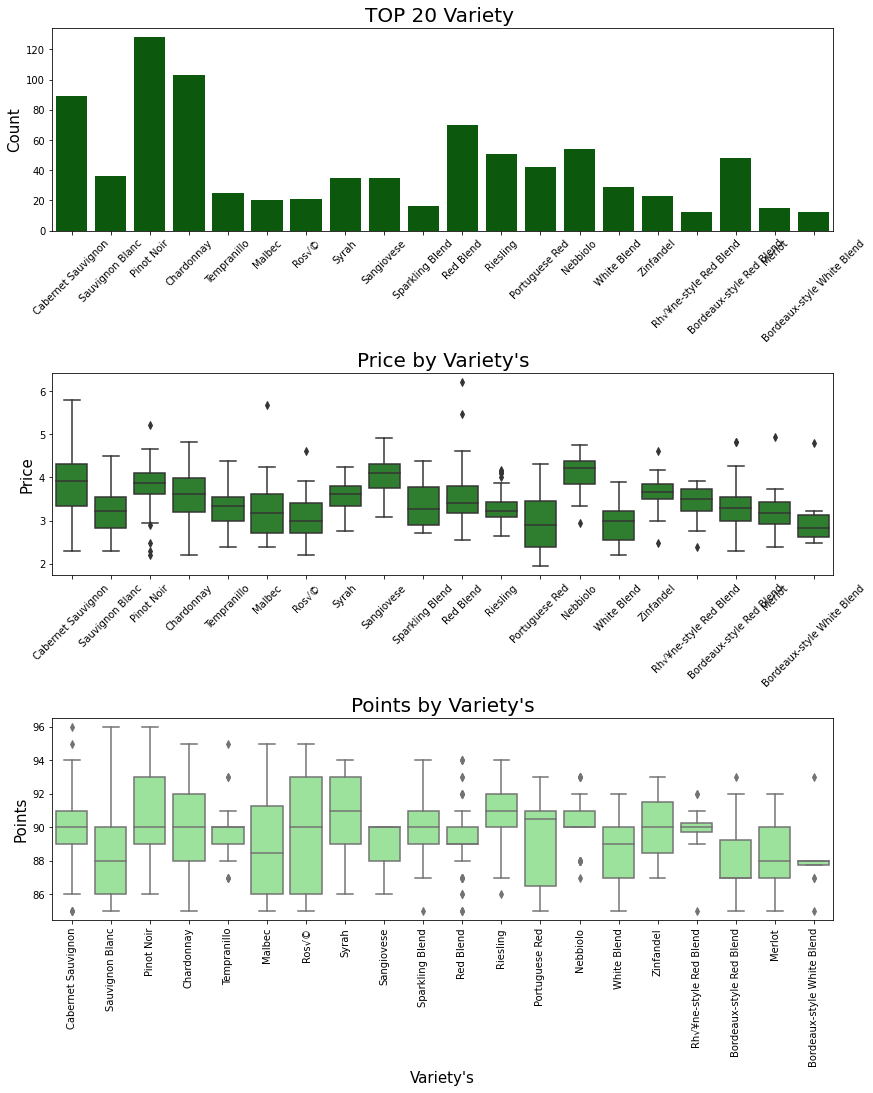

In [59]:
plt.figure(figsize=(14,16))

variety = df_wine1.variety.value_counts()[:20]

plt.subplot(3,1,1)
g = sns.countplot(x='variety', 
                  data=df_wine1.loc[(df_wine1.variety.isin(variety.index.values))], 
                  color='darkgreen')
g.set_title("TOP 20 Variety ", fontsize=20)
g.set_xlabel(" ", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.subplot(3,1,2)
g1 = sns.boxplot(y='price_log', x='variety',
                  data=df_wine1.loc[(df_wine1.variety.isin(variety.index.values))], 
                 color='forestgreen')
g1.set_title("Price by Variety's", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)

plt.subplot(3,1,3)
g2 = sns.boxplot(y='points', x='variety',
                  data=df_wine1.loc[(df_wine1.variety.isin(variety.index.values))], 
                 color='lightgreen')
g2.set_title("Points by Variety's", fontsize=20)
g2.set_xlabel("Variety's", fontsize=15)
g2.set_ylabel("Points", fontsize=15)
g2.set_xticklabels(g2.get_xticklabels(),rotation=90)

plt.subplots_adjust(hspace = 0.7,top = 0.9)

plt.show()

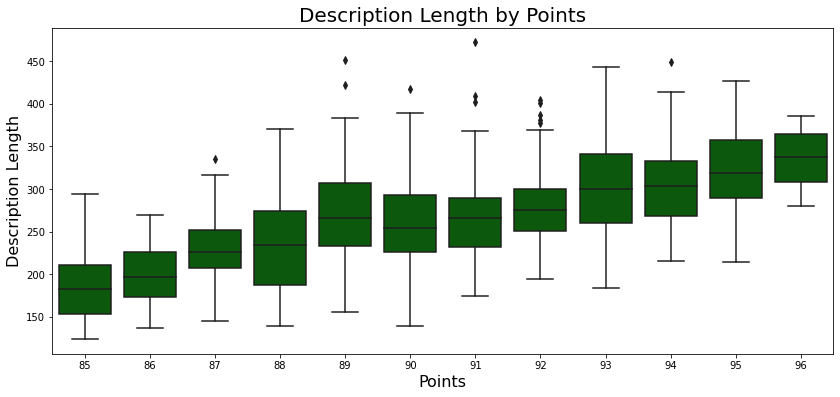

In [60]:
df_wine1 = df_wine1.assign(desc_length = df_wine1['description'].apply(len))

plt.figure(figsize=(14,6))
g = sns.boxplot(x='points', y='desc_length', data=df_wine1,
                color='darkgreen')
g.set_title('Description Length by Points', fontsize=20)
g.set_ylabel('Description Length', fontsize = 16) # Y label
g.set_xlabel('Points', fontsize = 16) # X label
plt.show()

Very cool! We can see that the wine's with highest points also have the biggest descriptions length. It's very interesting to understand.


## Scatter plot of the description length and the price

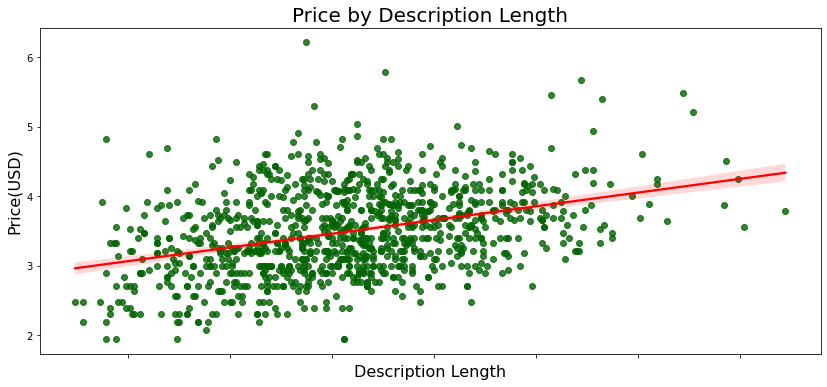

In [61]:
plt.figure(figsize=(14,6))

g = sns.regplot(x='desc_length', y='price_log', line_kws={'color':'red'},
                data=df_wine1, fit_reg=True, color='darkgreen', )
g.set_title('Price by Description Length', fontsize=20)
g.set_ylabel('Price(USD)', fontsize = 16) 
g.set_xlabel('Description Length', fontsize = 16)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.show()

## WORDCLOUDS OF DESCRIPTIONS

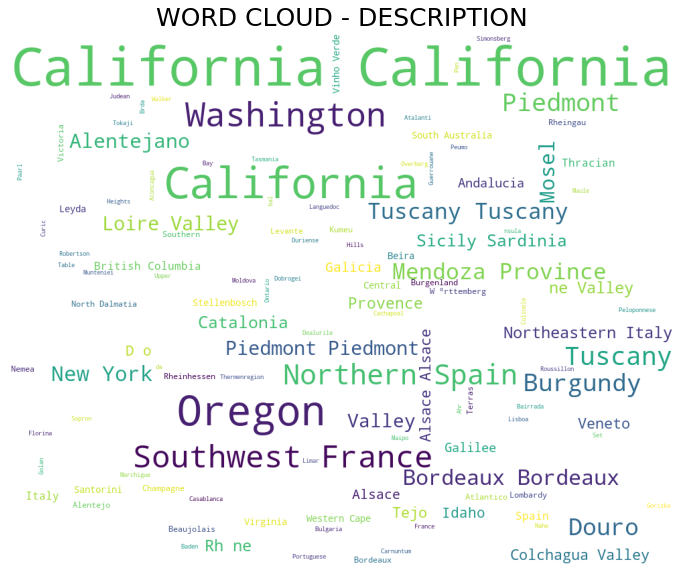

In [62]:

from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

newStopWords = ['fruit', "Drink", "black", 'wine', 'drink']

stopwords.update(newStopWords)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df_wine1['province'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - DESCRIPTION",fontsize=25)
plt.axis('off')
plt.show()

## WORDCLOUD OF PROVINCES

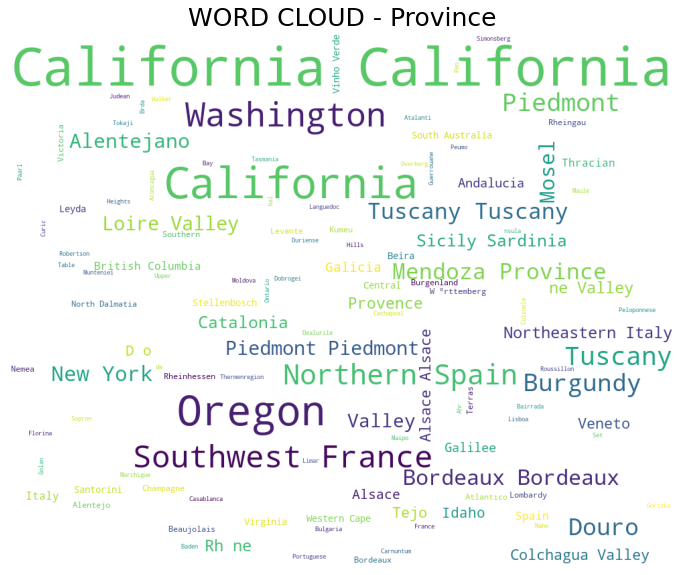

In [63]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df_wine1['province'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - Province",fontsize=25)
plt.axis('off')
plt.show()

KeyboardInterrupt: 

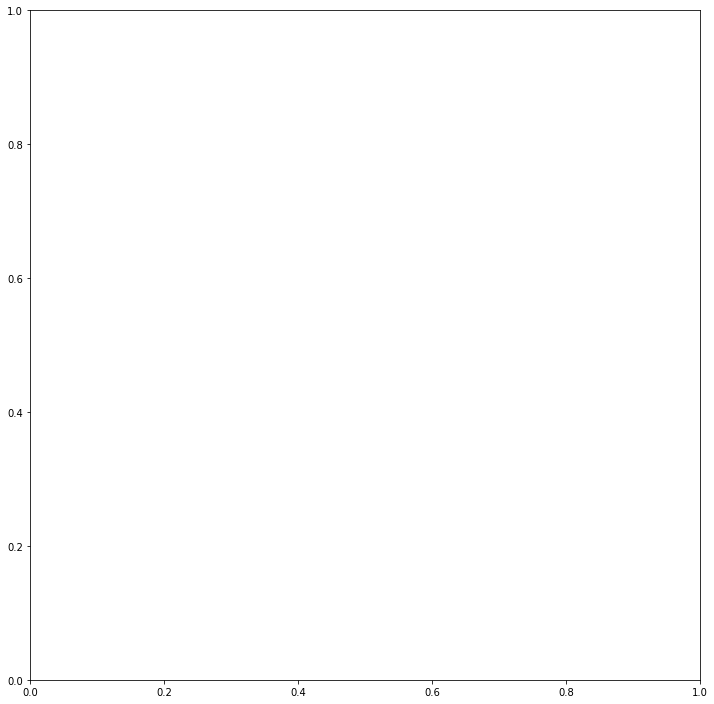

In [64]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df_wine1['variety'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - Variety",fontsize=25)
plt.axis('off')
plt.show()

In [ ]:
data = pd.read_csv('wine.csv', index_col=0)
countries = data.country.value_counts()


Let's Play with Word cloud we will map them to their country of Origin.

In [ ]:
# Limit top countries to those with more than 10 reviews
temp_dict = countries[countries>8].to_dict()
temp_dict['Other'] = countries[countries<8].sum()
less_countries = pd.Series(temp_dict)
less_countries.sort_values(ascending=False, inplace=True)

# Turn Series into DataFrame for display purposes
df = less_countries.to_frame()
df.columns=['Number of Reviews']
df.index.name = 'Country'
df

,Number of Reviews
Country,
US,504
France,172
Italy,163
Portugal,70
Spain,64
Other,31
Germany,27
Argentina,25
Chile,21


## Tree Map of the Top Countries

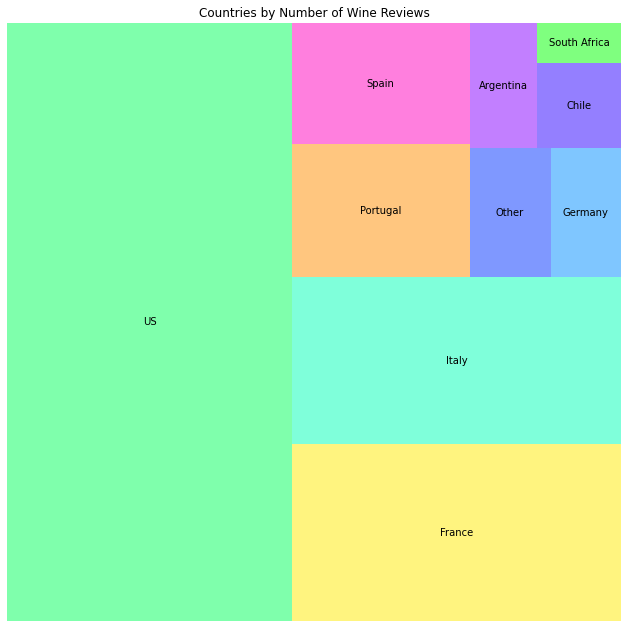

In [ ]:
# New colors for tree map since base ones are bland
cmap = plt.cm.gist_rainbow_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=15)
colors = [cmap(norm(value)) for value in range(15)]
np.random.shuffle(colors)

# Use squarify to plot the tree map with the custom colors
fig,ax = plt.subplots(1,1,figsize=(11,11))
sq.plot(sizes=less_countries.values, label=less_countries.index.values, alpha=0.5, ax=ax, color=colors)
plt.axis('off')
plt.title('Countries by Number of Wine Reviews')
plt.show()

## Cleaning the Reviews for Word Cloud Generation
This section uses a defaultdict to store each wine review description as an item in a list indexed by the country as the dictionary key. AKA a dictionary of lists. The default dict just makes it easier since we don't have to check if a key exists for a given country before we append to it's list. This allows us to complete the data processing within a lambda function since no assignment is necessary to generate the dictionary

In [ ]:
descriptions = defaultdict(list)
data.apply(lambda x: descriptions[x.country].append(x.description), axis=1)
descriptions['Italy'][0:5]

["Elegance, complexity and structure come together in this drop-dead gorgeous winethat ranks among Italy's greatest whites. It opens with sublime yellow spring flower, aromatic herb and orchard fruit scents. The creamy, delicious palate seamlessly combines juicy white peach, ripe pear and citrus flavors while white almond and savory mineral notes grace the lingering finish.",
 "Underbrush, scorched earth, menthol and plum steeped in spirits are some of the aromas that unfold on the glass. The big, chewy palate doles out ripe wild cherry, raspberry jam, ground pepper and licorice alongside firm, velvety tannins. You'll also detect the warmth of alcohol on the finish.",
 'Forest floor, tilled soil, mature berry and a whiff of new leather combine on this. The ripe palate offers fleshy black cherry, dried aromatic herb and tobacco, while fine-grained tannins give the finish some grip. Drink 2018‚Äì2023.',
 'Aromas of forest floor, violet, red berry and a whiff of dark baking spice unfold i

Next up is tokenization. For each countries reviews we need to do the following:
1. Combine all the reviews into one string
2. Remove all the unwanted punctuation
3. Split the string into a list of words
4. Take each word greater than 3 characters, make it lower case, and store it in a list
5. Join this final list together

Very possible there is a more straightforward solution but this works relatively quickly for the number of reviews/words being processed.

In [ ]:
unwanted_characters = re.compile('[^A-Za-z ]+')
for country in list(data.country.unique()):
    desc_string = ' '.join(descriptions[country])
    descriptions[country] = ' '.join([w.lower() for w in re.sub(unwanted_characters, ' ', desc_string).split() if len(w) > 3])

In [ ]:
descriptions['Italy'][0:500]

'elegance complexity structure come together this drop dead gorgeous winethat ranks among italy greatest whites opens with sublime yellow spring flower aromatic herb orchard fruit scents creamy delicious palate seamlessly combines juicy white peach ripe pear citrus flavors while white almond savory mineral notes grace lingering finish underbrush scorched earth menthol plum steeped spirits some aromas that unfold glass chewy palate doles ripe wild cherry raspberry ground pepper licorice alongside '

Great! Now we have a dictionary with each country's wine reviews tokenized and ready for word cloud generation.

## Cloud Generation
Let's define a function that takes a string of words, an image for masking the cloud, and an optional filename for saving the wordcloud to a file. It will return a wordcloud instance for us to work with/display in the notebook.

In [ ]:
wine_stopwords = ['drink','wine','wines','flavor','flavors','note','notes','palate','finish','hint','hints','show','shows']
for w in wine_stopwords:
    STOPWORDS.add(w)

In [ ]:
def generate_country_wordcloud(words, mask_image, filename=None, colormap='jet'):
    mask = np.array(Image.open(mask_image))
    wc = WordCloud(background_color="grey", max_words=3000, mask=mask, stopwords=STOPWORDS, colormap=colormap)
    wc.generate(words)
    if filename:
        wc.to_file(filename)
    return wc

In [ ]:
masks = dict()
"""masks['Argentina'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/argentina_bw_map.jpg'
masks['Australia'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/australia_bw_map.jpg'
masks['Austria'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/austria_bw_map.jpg'
masks['Chile'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/chile_bw_map.jpg'"""
masks['France'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/france_bw_map.jpg'
"""masks['Italy'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/italy_bw_map.jpg'
masks['Portugal'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/portugal_bw_map.jpg'
masks['Spain'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/spain_bw_map.jpg'"""
masks['US'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/usa_bw_map.jpg'
"""masks['Germany'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/germany_bw_map.jpg'
masks['Israel'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/israel_bw_map.jpg'
masks['New Zealand'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/newzealand_bw_map.jpg'"""
masks['South Africa'] = '/Users/danavanwyk/Desktop/Hyperion Dev Data Science/2- Data Analytics and Exploration/Task 17/Country Images/southafrica_bw_map.jpg'

Time to generate the word clouds!

# **United States**

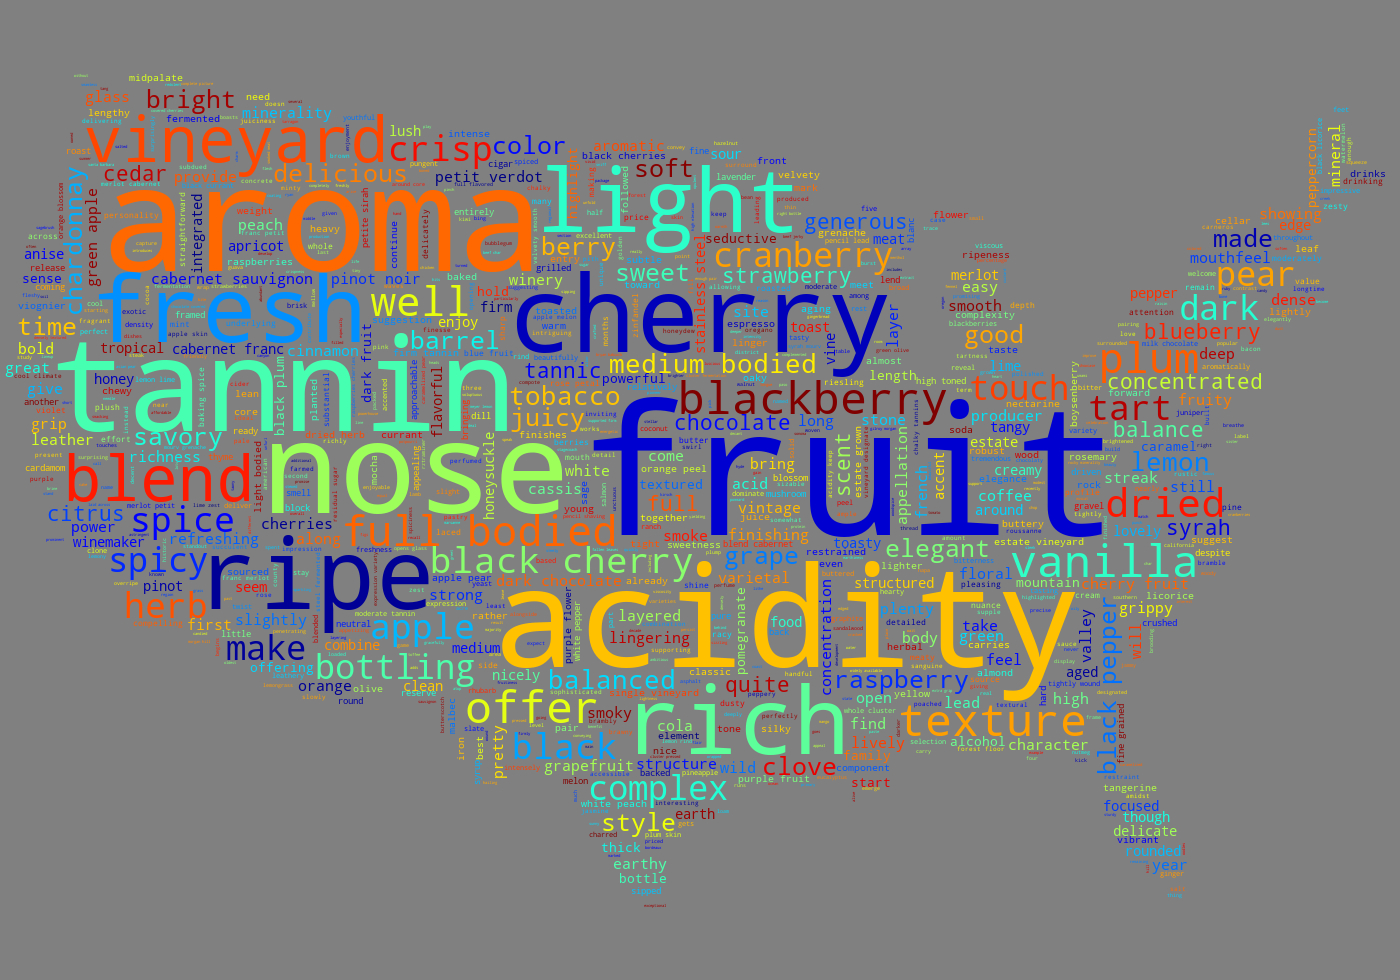

In [ ]:
us_wc = generate_country_wordcloud(descriptions['US'], masks['US'], 'US.jpg')
us_wc.to_image()

# **France**

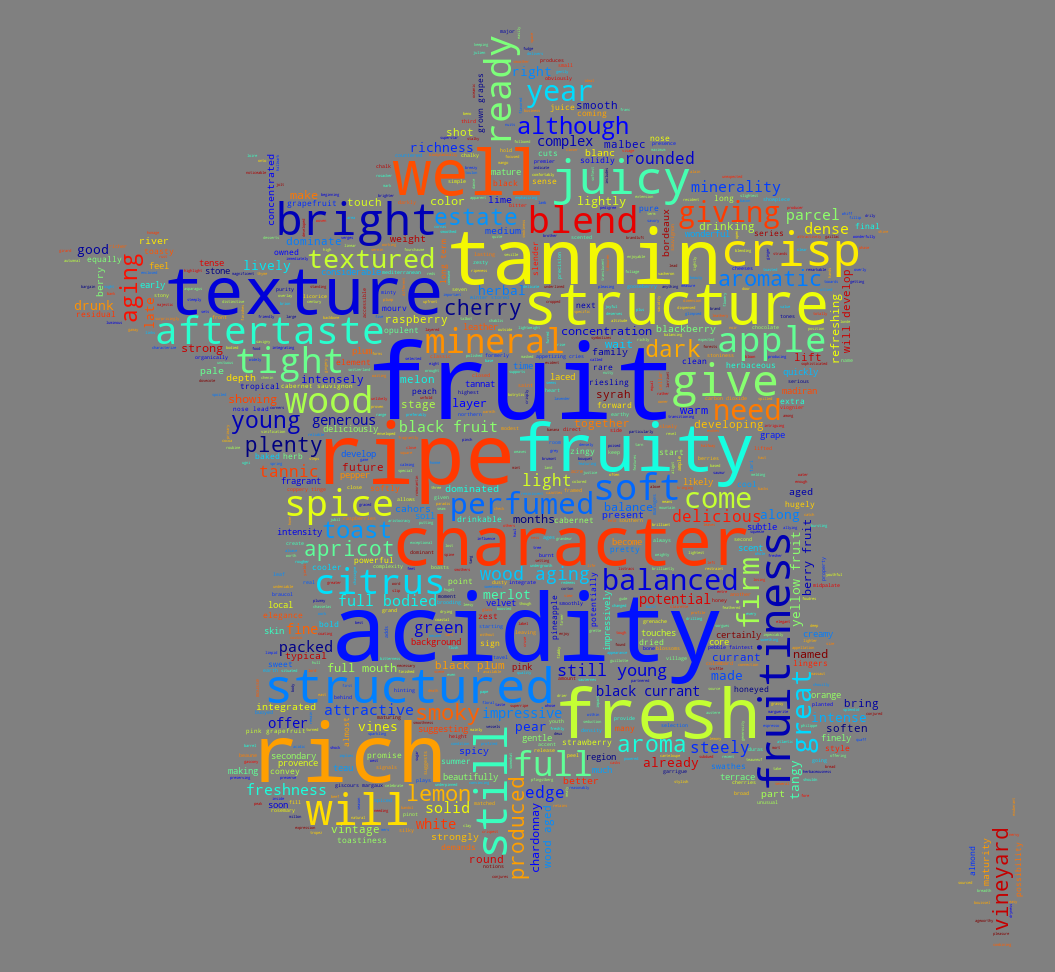

In [ ]:
france_wc = generate_country_wordcloud(descriptions['France'], masks['France'], 'France.jpg')
france_wc.to_image()

# **South Africa**

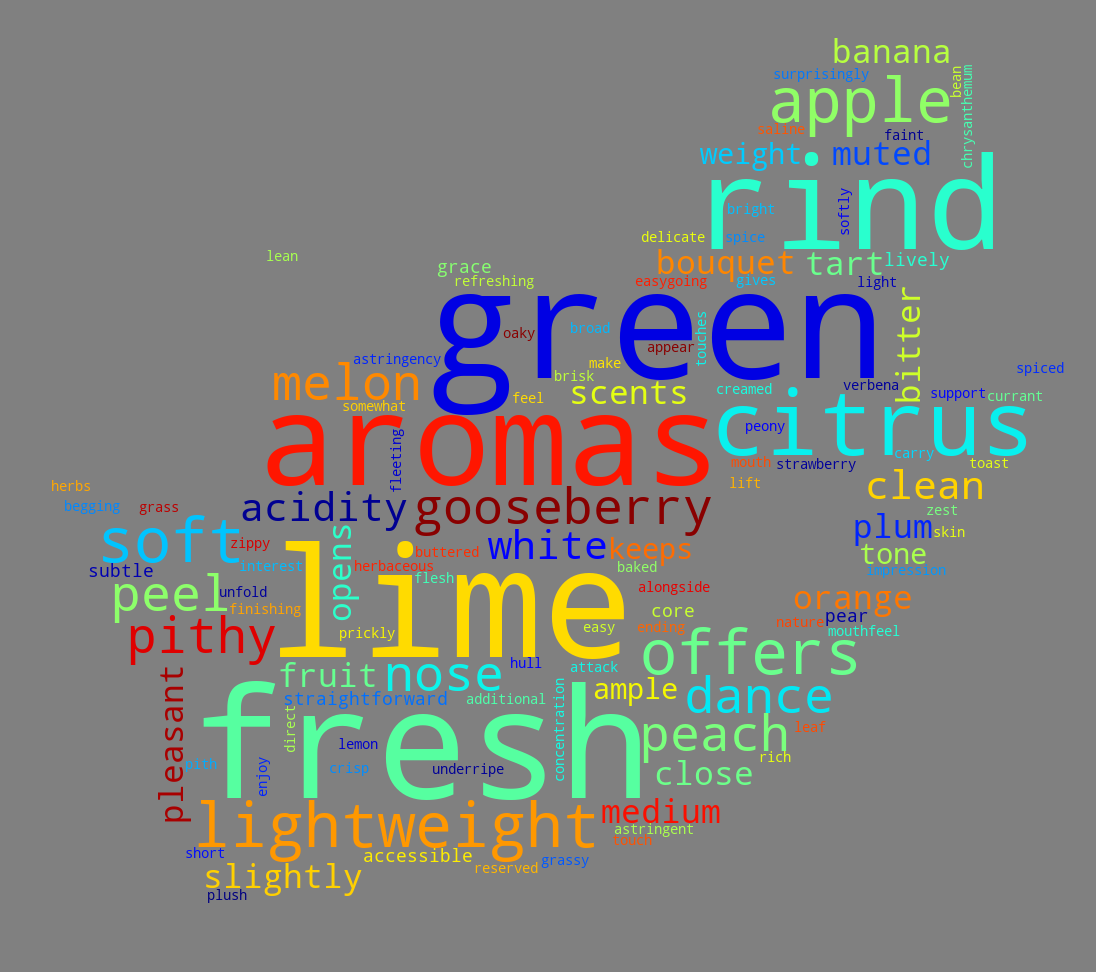

In [ ]:
south_africa_wc = generate_country_wordcloud(descriptions['South Africa'], masks['South Africa'], 'SouthAfrica.jpg')
south_africa_wc.to_image()